# Multidimensional Double Well

using LREX

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
import openmm
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [4]:
import torch

import bgflow as bg
from bgflow.utils.types import assert_numpy
ctx = {'dtype': torch.float32, 'device': torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')}
ctx

{'dtype': torch.float32, 'device': device(type='cuda', index=0)}

In [5]:
#define the openmm system
class DoubleWellOpenMM():
    def __init__(self, model=bg.ModifiedWolfeQuapp(2)):
        '''
        Simulate the multidimensional double-well system using OpenMM.
        Since all degrees of freedom but the firts two are uncoupled, 
        we use N particles in 3D instead of one particle in dim dimensions.
        '''
        dim = model.dim
        n_particles = 1 + (dim - 1) // 3
        partial_dim = dim % 3
        
        system = openmm.System()
        
        #first particle feels WQ potential
        model_potential = openmm.CustomExternalForce(model.potential_str)
        model_potential.addParticle(0)
        system.addParticle(1.0)
        system.addForce(model_potential)
        #other particles feel an harmonic potential
        if dim > 3:
            normal_potential = openmm.CustomExternalForce(f'{model._scale2}*0.5*(x^2+y^2+z^2)')
            for i in range(1, n_particles-bool(partial_dim)):
                normal_potential.addParticle(i)
                system.addParticle(1.0)
            system.addForce(normal_potential)
            #do not add a potential to the left over MD dimensions
            if partial_dim > 0:
                if partial_dim == 1:
                    dof = 'x^2'
                elif partial_dim == 2:
                    dof = '(x^2+y^2)'
                else:
                    assert False
                partial_potential = openmm.CustomExternalForce(f'{model._scale2}*0.5*{dof}')
                partial_potential.addParticle(n_particles-1)
                system.addParticle(1.0)
                system.addForce(partial_potential)
        
        #some arbitrary initial positions
        init_posA = np.array([[-1.5, 0.7, 0]]) #basin A
        init_posB = np.array([[2, -1.0, 0]]) #basin B
        if dim > 3:
            init_posA = np.append(init_posA, [0.0]*((n_particles-1)*3)).reshape(-1, 3)
            init_posB = np.append(init_posB, [0.0]*((n_particles-1)*3)).reshape(-1, 3)
        
        #properties:
        self.dim = dim #intrinsic dimension
        self.MD_dim = 3 * n_particles #MD dimension (multiple of 3), MD_dim >= dim
        
        self.system = system
        self.topology = openmm.app.topology.Topology()
        
        self.positions = init_posA
        self.pos_basinA = init_posA
        self.pos_basinB = init_posB

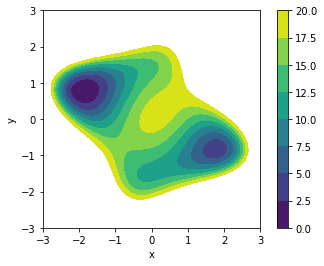

In [11]:
#some plotting functions
model2D = bg.ModifiedWolfeQuapp(2)
nbins = 101
x_bins = np.linspace(-3, 3, nbins)
y_bins = x_bins
XY = np.array(np.meshgrid(x_bins, y_bins))
DoubleWellXY = model2D.energy(torch.as_tensor(XY.T).reshape(nbins**2,2)).view(nbins, nbins).cpu().numpy().T

FES = np.zeros(len(x_bins))
for i in range(len(x_bins)):
    FES[i] = -np.logaddexp.reduce(-DoubleWellXY[:,i])
FES -= min(FES)

def plot_doublewell(traj=None, traj2=None, grid=False):
    levels = np.linspace(0,20,9)
    
    plt.contourf(XY[0], XY[1], DoubleWellXY, levels)
    plt.colorbar()
    plt.gca().set_box_aspect(1)
    plt.xlabel('x')
    plt.ylabel('y')
    if grid:
        plt.grid(linestyle='dashed')
    if traj is not None:
        xy_samples = assert_numpy(traj).reshape(len(traj),-1)[:,:2]
        plt.plot(xy_samples[:,0], xy_samples[:,1], '.r')
    if traj2 is not None:
        xy_samples = assert_numpy(traj2).reshape(len(traj2),-1)[:,:2]
        plt.plot(xy_samples[:,0], xy_samples[:,1], '+m')
    plt.show()
    
def plot_fes(data, temp=1/kB, bins='auto', w=None, show=True):
    x_samples = assert_numpy(data)
    beta = 1/(temp*kB)
    FES_t = [-np.logaddexp.reduce(-beta*DoubleWellXY[:,i]) for i in range(len(x_bins))]
    FES_t -= min(FES_t)
    plt.plot(x_bins, FES_t, '--', label='reference')
    if w is not None and bins == 'auto':
        bins = 50
    hist, edges = np.histogram(x_samples, bins=bins, weights=w)
    fes_estimate = -np.log(np.where(hist!=0, hist/hist.max(), np.nan))
    xrange = edges[:-1]+(edges[1]-edges[0])/2
    plt.plot(xrange, fes_estimate, label='estimate')
    plt.xlabel('x')
    plt.ylabel('FES')
    plt.ylim(0, FES_t[-1])
    plt.xlim(x_bins[0], x_bins[-1])
    plt.legend()
    if show:
        plt.show()
    fes_estimate[np.isnan(fes_estimate)] = 1000
    
    print(f'ref DeltaF: {np.logaddexp.reduce(-FES_t[x_bins<0])-np.logaddexp.reduce(-FES_t[x_bins>0]):g} [kBT]')
    print(f'    DeltaF: {np.logaddexp.reduce(-fes_estimate[xrange<0])-np.logaddexp.reduce(-fes_estimate[xrange>0]):g} [kBT]')

plot_mueller()

## Get MD samples

In [12]:
base_dim = 2**12
temp = 1 / kB
highT = 5 / kB

model = bg.ModifiedWolfeQuapp(base_dim)
base_dim

4096

In [13]:
#setup the system
class WolfeQuappOpenMM():
    def __init__(self, dim, **kwargs):
        model = bg.ModifiedWolfeQuapp(dim, **kwargs)
        WolfeQuapp_potential = openmm.CustomExternalForce(model.potential_str)
        WolfeQuapp_potential.addParticle(0)
        # print(WolfeQuapp_potential.getEnergyFunction())

        system = openmm.System()
        system.addParticle(1.0)
        system.addForce(WolfeQuapp_potential)
        if dim > 3:
            normal_potential = openmm.CustomExternalForce(f'{model._scale2}*0.5*(x^2+y^2+z^2)')
            # print(normal_potential.getEnergyFunction())
            for i in range((dim-1)//3):
                normal_potential.addParticle(i+1)
                system.addParticle(1.0)
            system.addForce(normal_potential)

        topology = openmm.app.topology.Topology()
        init_posA = np.array([[-1.5, 0.7, 0]]) #basin A
        init_posB = np.array([[2, -1.0, 0]]) #basin B
        if dim > 3:
            init_posA = np.append(init_posA, [0.0]*((dim-1)//3)*3).reshape(-1, 3)
            init_posB = np.append(init_posB, [0.0]*((dim-1)//3)*3).reshape(-1, 3)
            
        self.system = system
        self.topology = topology
        self.positions = init_posA
        self.pos_basinA = init_posA
        self.pos_basinB = init_posB
        self.base_dim = 3 * len(init_posA)
        self.dim = dim

modelMD = WolfeQuappOpenMM(base_dim)
modelMD.positions.shape, modelMD.base_dim, modelMD.dim

((1366, 3), 4098, 4096)

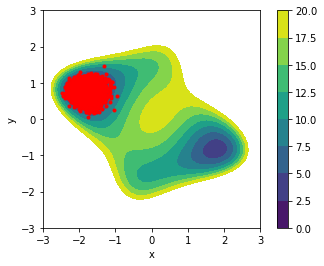

CPU times: user 1min 21s, sys: 3.71 s, total: 1min 25s
Wall time: 1min 19s


In [14]:
%%time
#sample target

pace = 100
n_iter = 10_000
n_equil = 100

integrator = openmm.LangevinMiddleIntegrator(temp*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond)
simulation = openmm.app.Simulation(modelMD.topology, modelMD.system, integrator)
simulation.context.setPositions(modelMD.positions)

#equilibrate
simulation.step(pace*n_equil)

#run MD
data = np.full((n_iter, *modelMD.positions.shape), np.nan)
for n in range(n_iter):
    simulation.step(pace)
    data[n] = simulation.context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
    if (n+1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plot_doublewell(data[:n+1])
    print(f'sampling...  {n/n_iter:.1%}', end='\r')

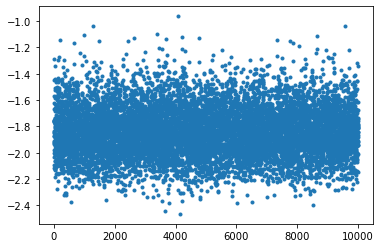

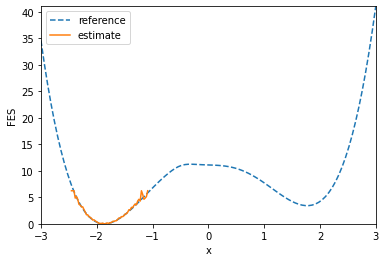

ref DeltaF: 3.31506 [kBT]
    DeltaF: inf [kBT]


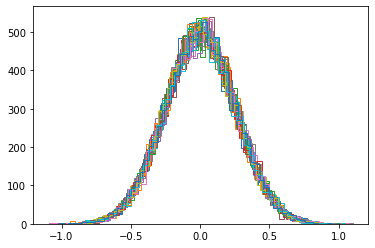

In [15]:
plt.plot(data[:,0,0], '.')
plt.show()
plot_fes(data[:,0,0], temp)

plt.hist(data[:,0,2], bins='auto', histtype='step')
for j in range(min(10, (base_dim-1)//3)):
    for i in range(3):
        plt.hist(data[:,1+j,i], bins='auto', histtype='step')
plt.show()

In [16]:
target_data = torch.as_tensor(data.reshape(len(data),-1)[:,:base_dim], **ctx)
target_data.shape

torch.Size([10000, 4096])

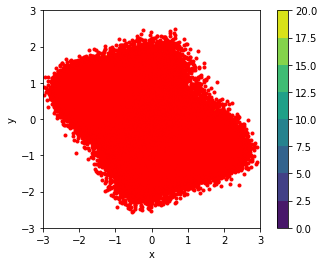

CPU times: user 10min 3s, sys: 25.1 s, total: 10min 28s
Wall time: 9min 56s


In [17]:
%%time
#sample prior

# pace = 100
len_training = 5*100*2**7
n_iter = len_training + 10_000
# n_iter = 20_000
# n_equil = 100

integrator = openmm.LangevinMiddleIntegrator(highT*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond)
simulation = openmm.app.Simulation(modelMD.topology, modelMD.system, integrator)
simulation.context.setPositions(modelMD.positions)

#equilibrate
simulation.step(pace*n_equil)

#run MD
data = np.full((n_iter, *modelMD.positions.shape), np.nan)
for n in range(n_iter):
    simulation.step(pace)
    data[n] = simulation.context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
    if (n+1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plot_doublewell(data[:n+1])
    print(f'sampling...  {n/n_iter:.1%}', end='\r')

In [18]:
5*100*2**7

64000

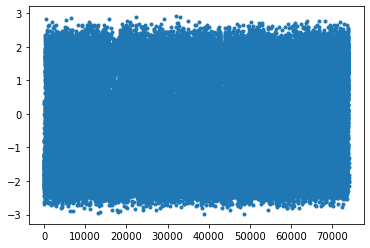

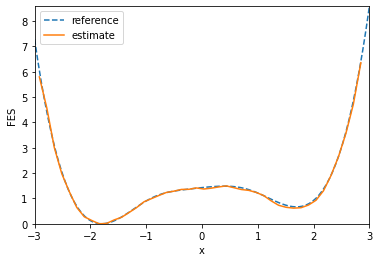

ref DeltaF: 0.52824 [kBT]
    DeltaF: 0.460795 [kBT]


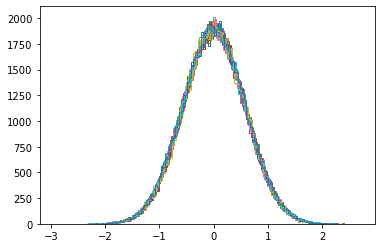

In [19]:
plt.plot(data[:,0,0], '.')
plt.show()
plot_fes(data[:,0,0], highT)

plt.hist(data[:,0,2], bins='auto', histtype='step')
for j in range(min(10, (base_dim-1)//3)):
    for i in range(3):
        plt.hist(data[:,1+j,i], bins='auto', histtype='step')
plt.show()

In [20]:
prior_data = torch.as_tensor(data.reshape(len(data),-1)[:len_training,:base_dim], **ctx)
testing_data = torch.as_tensor(data.reshape(len(data),-1)[len_training:,:base_dim], **ctx)
# prior_data = torch.as_tensor(data.reshape(len(data),-1)[:n_iter//2,:base_dim], **ctx)
# testing_data = torch.as_tensor(data.reshape(len(data),-1)[n_iter//2:,:base_dim], **ctx)
prior_data.shape, testing_data.shape

(torch.Size([64000, 4096]), torch.Size([10000, 4096]))

## Setup the flow

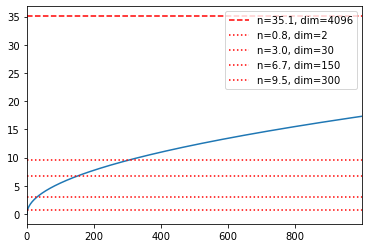

(4096, 35.05424368033063)

In [293]:
dim = 2**12 #base_dim #2**10 #
store_energies = False

assert dim <= base_dim
assert dim % 2 == 0
model = bg.ModifiedWolfeQuapp(dim)

x = np.arange(1000)
def rep_estimate(x):
    x_ref = 30
    n_ref = 3
    return n_ref*np.sqrt(x/x_ref)
plt.plot(x, rep_estimate(x)) #at dim=10 we need 2 replicas
n_i = rep_estimate(dim)
plt.axhline(n_i, ls='--', c='r', label=f'n={n_i:.1f}, dim={dim}')
for i in [2, 30, 150, 300]:
    # plt.axvline(i, ls=':', c='r')
    n_i = rep_estimate(i)
    plt.axhline(n_i, ls=':', c='r', label=f'n={n_i:.1f}, dim={i}')
plt.xlim(x[0], x[-1])
plt.legend()
plt.show()
dim, rep_estimate(dim)

In [294]:
# def inverse_estimate(n):
#     x_ref = 30
#     n_ref = 3
#     return x_ref*(n/n_ref)**2
# n = np.arange(20)
# plt.plot(n, inverse_estimate(n)) #at dim=10 we need 2 replicas
# int(inverse_estimate(15)/2)*2

In [295]:
CLIPPING = False #100
target = bg.ModifiedWolfeQuapp(dim, beta=1/(temp*kB)).to(**ctx)

if CLIPPING:
    grad_clipping = bg.utils.ClipGradient(clip=CLIPPING, norm_dim=1)
    target = bg.GradientClippedEnergy(target, grad_clipping).to(**ctx)
    print('clipping atom forces at', CLIPPING)

In [296]:
lim = 3.5
shuffle = True #it improves results, also with a single epoch
prior = bg.CustomDistribution(
    bg.ModifiedWolfeQuapp(dim, beta=1/(highT*kB)).to(**ctx), 
    bg.DataSetSampler(prior_data[:,:dim], shuffle=shuffle, **ctx)
)

In [297]:
#visualize the latent space
edge = lim
latentGrid = np.linspace(-edge, edge, nbins)
latentX, latentY = np.meshgrid(latentGrid, latentGrid)
if dim > 2:
    latentXY = torch.as_tensor(np.c_[latentX.flatten(),latentY.flatten(),np.zeros((nbins**2, dim-2))], **ctx)
else:
    latentXY = torch.as_tensor(np.c_[(latentX.flatten(),latentY.flatten())], **ctx)
def plot_latent(flow, traj=None, traj2=None, vmax=30):
    with torch.no_grad():
        mappedMesh, dlogp = flow(latentXY)
        mappedDoubleWellXY = assert_numpy((target.energy(mappedMesh)-dlogp).view(nbins,nbins))
    plt.imshow(mappedDoubleWellXY-mappedDoubleWellXY.min(), vmax=vmax, origin='lower', extent=(-edge,edge,-edge,edge))
    plt.colorbar()
    plt.gca().set_box_aspect(1)
    plt.xlabel('latent x')
    plt.ylabel('latent y')
    if traj is not None:
        samples = assert_numpy(traj).reshape(len(traj),-1)[:,:2]
        plt.plot(samples[:,0], samples[:,1], '.r')
    if traj2 is not None:
        samples = assert_numpy(traj2).reshape(len(traj2),-1)[:,:2]
        plt.plot(samples[:,0], samples[:,1], '.m')
    plt.show()

#define a grid in latent
grid = np.linspace(-lim,lim,20)
myX, myY = np.meshgrid(grid,grid)
if dim > 2:
    xy = torch.as_tensor(np.c_[myX.flatten(), myY.flatten(), np.zeros((len(myX.flatten()), dim-2))], **ctx)
else:
    xy = torch.as_tensor(np.c_[myX.flatten(), myY.flatten()], **ctx)
latentMask = assert_numpy(prior.energy(xy).view(-1))<5

In [298]:
# chose your flow
zero_param = True
spline_flow = False

n_coupling = 1 #full couplings, with a swap
n_splitting = 2
# splitting = [np.arange(0,dim,2), np.arange(1,dim,2)] #
hidden_nodes = [2**7, 2**7]

In [299]:
if spline_flow:
    print('spline flow')
    limp = lim + 1e-4
    n_bins = 8
    nodes = [(dim-dim//n_splitting), *hidden_nodes, (3*n_bins+1)*(dim//n_splitting)]
    # bg.nn.flow.transformer.spline.DEFAULT_MIN_BIN_HEIGHT = 1e-3 #0.05
    # bg.nn.flow.transformer.spline.DEFAULT_MIN_BIN_WIDTH = 1e-3 #0.05
    # bg.nn.flow.transformer.spline.DEFAULT_MIN_DERIVATIVE = 1e-3 #0.05
else:
    print('affine flow')
    nodes = [dim-dim//n_splitting, *hidden_nodes, dim//n_splitting]

half_flow = []
for _ in range(2):
    layers = []
    for __ in range(n_coupling):
        for i in range(n_splitting):
            # layers.append(bg.SwapFlow())
            if spline_flow:
                transformer = bg.ConditionalSplineTransformer(
                    bg.DenseNet(nodes, activation=torch.nn.ReLU()), 
                    left=-limp, right=limp, bottom=-limp, top=limp
                )
            else:
                transformer = bg.AffineTransformer(
                    shift_transformation=bg.DenseNet(nodes, activation=torch.nn.ReLU()),
                    scale_transformation=bg.DenseNet(nodes, activation=torch.nn.ReLU())
                )
            layers.append(bg.CouplingFlow(transformer, transformed_indices=[i], cond_indices=[j for j in range(n_splitting) if j != i]))
    half_flow.append(bg.SequentialFlow(layers))
half_flow[1].load_state_dict(half_flow[0].state_dict())

splitting = [dim//n_splitting] * n_splitting
flow = bg.SequentialFlow([
        bg.SplitFlow(*splitting), 
        half_flow[0], 
        bg.InverseFlow(half_flow[1]), 
        bg.MergeFlow(*splitting)
    ]).to(**ctx)
generator = bg.BoltzmannGenerator(prior, flow, target)

tot_param = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print(f"Number of Parameters: {tot_param:_}")

affine flow
Number of Parameters: 4_343_812


In [300]:
if zero_param:
    print('Setting parameters to zero')
    for p in flow.parameters():
        p.data.fill_(0)
        # p.data.normal_(std=1e-3)
with torch.no_grad():
    print(f'Delta max: {(xy - flow(xy)[0]).abs().max().item():g}')
    print(f'dlogp max: {flow(xy)[1].abs().max().item():g}')

Setting parameters to zero
Delta max: 0
dlogp max: 0


In [301]:
#setup training
batchsize = 2**7
w_likelihood = 0

optimizer = torch.optim.Adam(generator.parameters(), lr=1e-2)
trainer = bg.KLTrainer(generator, optimizer)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 1/10, verbose=True)
if shuffle:
    prior._delegate_sampler.reshuffle_()
if w_likelihood == 0:
    print('energy training only')

Adjusting learning rate of group 0 to 1.0000e-02.
energy training only


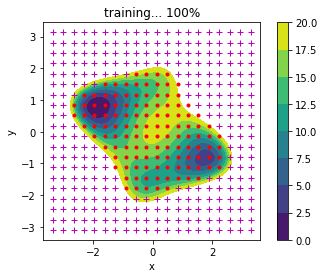

CPU times: user 31.6 s, sys: 7.62 s, total: 39.2 s
Wall time: 23.9 s


In [302]:
%%time
with torch.no_grad():
    mapped_xy = flow(xy)[0]
    plot_doublewell(mapped_xy[latentMask], mapped_xy[~latentMask])

stride = 5
n_iter = 100
#run energy training
for i in range(n_iter):
    if i % (n_iter//4) == 0 and i != 0:
        scheduler.step()
    trainer.train(stride, target_data[:,:dim], batchsize=batchsize, w_likelihood=w_likelihood)#, n_print=100)
    # plt.plot(trainer.reporter._raw[-1])
    # plt.show()
    clear_output(wait=True)
    plt.title(f'training... {(i+1)/(n_iter):.0%}')
    with torch.no_grad():
        mapped_xy = flow(xy)[0]
        plot_doublewell(mapped_xy[latentMask], mapped_xy[~latentMask])
        # plot_doublewell(flow(xy[latentMask])[0], flow(xy[~latentMask])[0])
        # plot_latent(flow)

KLD from 10256.3 to 5349.82
NLL from 410.122 to -1244.21


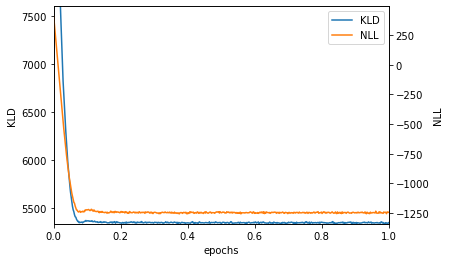

In [303]:
fig, ax = plt.subplots()
report = trainer.reporter._raw[0]
epochs = np.linspace(0, len_training/len(report)/batchsize, len(report))
line1, = ax.plot(epochs, report, label='KLD') #TODO: better reporter
ax.set_ylim(min(report), np.percentile(report,98))
ax.set_ylabel('KLD')
# ax.set_xlim(0, len(report))
ax.set_xlim(epochs[0], epochs[-1])
ax.set_xlabel('epochs')
print(f'KLD from {report[0]:g} to {report[-1]:g}')
if len(trainer.reporter._raw) == 2:
    report = trainer.reporter._raw[1]
    ax2 = ax.twinx()
    ax2.plot([], []) #fixes color
    line2, = ax2.plot(epochs, report, label='NLL')
    ax2.set_ylabel('NLL')
    print(f'NLL from {report[0]:g} to {report[-1]:g}')
    plt.legend([line1, line2], ['KLD', 'NLL'])
plt.show()

## Visualize results

PRIOR
Sampling efficiency: 0.01%
ESS: 1


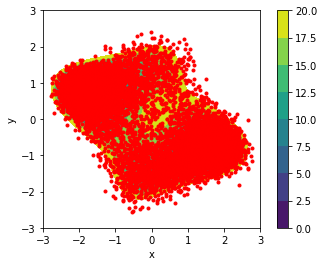

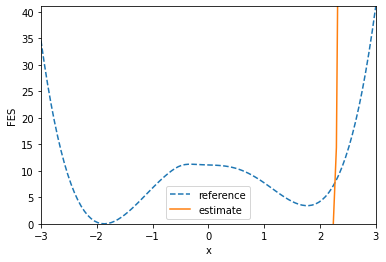

ref DeltaF: 3.31506 [kBT]
    DeltaF: -25.761 [kBT]

BOLTZMANN GENERATOR
Sampling efficiency: 9.29%
ESS: 929.229


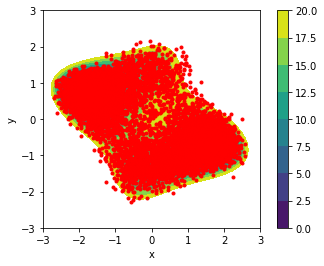

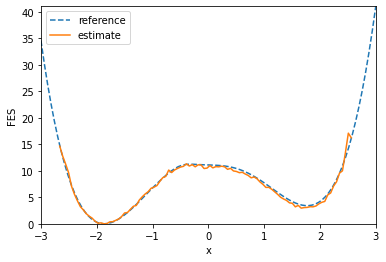

ref DeltaF: 3.31506 [kBT]
    DeltaF: 2.84 [kBT]


In [304]:
# n_samples = len(testing_data)
if shuffle:
    prior._delegate_sampler.reshuffle_()
with torch.no_grad():
    print('PRIOR')
    # samples = torch.cat((prior_data, testing_data))[:,:dim]
    prior_samples = testing_data[:,:dim]
    prior_ene = prior.energy(prior_samples)
    logw = prior_ene - target.energy(prior_samples)
    logw -= logw.max()
    print(f'Sampling efficiency: {bg.sampling_efficiency(logw).item():.2%}')
    print(f'ESS: {bg.effective_sample_size(logw).item():g}')
    plot_doublewell(prior_samples)
    plot_fes(prior_samples[:,0].cpu(), temp, w=logw.exp().view(-1).cpu(), bins=100)
    
    print('\nBOLTZMANN GENERATOR')
    # samples, logw = generator.sample(n_samples, with_log_weights=True)
    samples, dlogp = flow(prior_samples)
    logw = prior_ene + dlogp - target.energy(samples)
    logw -= logw.max()
    print(f'Sampling efficiency: {bg.sampling_efficiency(logw).item():.2%}')
    print(f'ESS: {bg.effective_sample_size(logw).item():g}')
    plot_doublewell(samples)
    plot_fes(samples[:,0].cpu(), temp, w=logw.exp().view(-1).cpu(), bins=100)
    # plot_fes(samples[:,0], highT, bins=100) #NB affine flow basically does not touch the 2D plane with two minima!

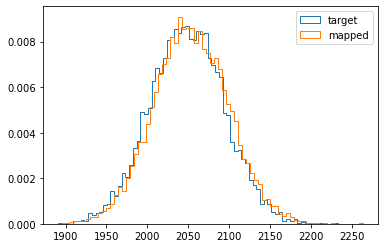

In [305]:
hist_opt = {'bins': 75, 'histtype': 'step', 'density': True}
# prior._delegate_sampler.reshuffle_()
with torch.no_grad():
    # mapped_samples, prior_samples, dlogp, logw = generator.sample(n_samples, with_latent=True, with_dlogp=True, with_log_weights=True)
    # logw -= logw.max()
    mapped_samples = samples
    prior_samples = testing_data[:,:dim]
    plt.hist(target.energy(target_data[:,:dim]).view(-1).cpu(), **hist_opt, label='target')
    # plt.hist(target.energy(prior_samples).view(-1).cpu(), **hist_opt, label='prior')
    plt.hist(target.energy(mapped_samples).view(-1).cpu(), **hist_opt, label='mapped')
    # plt.hist(target.energy(mapped_samples).view(-1).cpu(), weights=logw.exp().view(-1).cpu(), **hist_opt, label='reweighted')
    if store_energies:
        np.savez(f'energies-dim{dim}.npz', 
                 target=target.energy(target_data[:,:dim]).view(-1).cpu(),
                 prior=target.energy(prior_samples).view(-1).cpu(),
                 mapped=target.energy(mapped_samples).view(-1).cpu(),
                 weights=logw.exp().view(-1).cpu()
                )
plt.legend()
plt.show()

In [306]:
with torch.no_grad():
    energies = [assert_numpy(target.energy(target_data[:,:dim]).view(-1)), 
                assert_numpy(target.energy(mapped_samples).view(-1)), 
                assert_numpy(target.energy(prior_samples).view(-1))
               ]
np.save(f'DoubleWell{dim}-NFenergies.pny', energies)

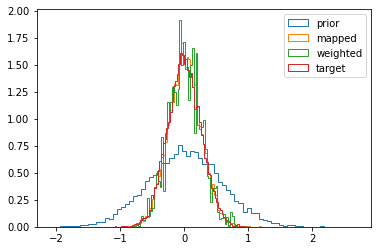

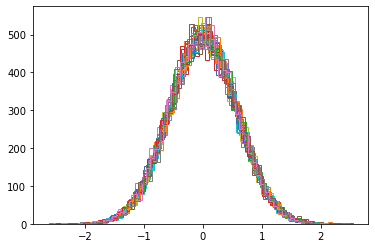

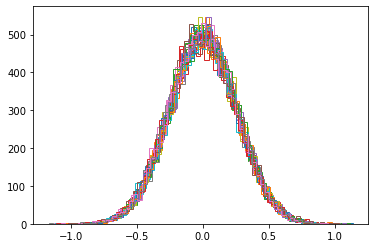

In [307]:
if dim > 2:
    # plt.hist(data[:,0,2], bins='auto', density=True, histtype='step')
    # plt.hist(generator.sample_to_cpu(10000)[:,2], bins='auto', density=True, histtype='step')
    # plt.hist(training_data[:,2], bins='auto', density=True, histtype='step')
    plt.hist(prior_samples[:,2].cpu(), **hist_opt, label='prior')
    plt.hist(mapped_samples[:,2].cpu(), **hist_opt, label='mapped')
    plt.hist(mapped_samples[:,2].cpu(), **hist_opt, weights=logw.exp().view(-1).cpu(), label='weighted')
    plt.hist(target_data[:,2].cpu(), **hist_opt, label='target')
    plt.legend()
    plt.show()
    for i in range(1, min(dim, 30)-1):
        plt.hist(prior_samples[:,-i].cpu(), bins='auto', histtype='step')
    plt.show()
    for i in range(1, min(dim, 30)-1):
        plt.hist(mapped_samples[:,-i].cpu(), bins='auto', histtype='step')
    # for j in range((dim-1)//3):
    #     for i in range(3):
    #         plt.hist(data[:,1+j,i], bins='auto', histtype='step')
    plt.show()
else:
    maskA = np.array([y>x+1.3 for x,y in data[:,0,:2]])
    mydata = data[:,0,:2]
    with torch.no_grad():
        mapped_data = flow(torch.as_tensor(mydata, **ctx), inverse=True)[0]
        plot_doublewell(mydata, mapped_data)

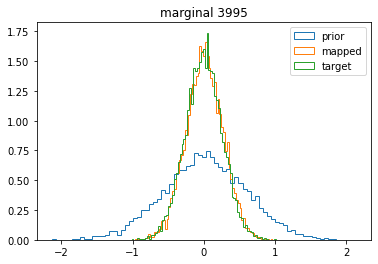

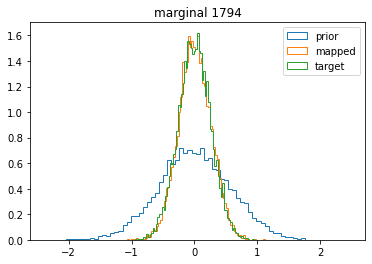

In [308]:
for i in [np.random.randint(0, dim), np.random.randint(0, dim)]: #range(dim):
    plt.title(f'marginal {i}')
    plt.hist(prior_samples[:,i].cpu(), **hist_opt, label='prior')
    plt.hist(mapped_samples[:,i].cpu(), **hist_opt, label='mapped')
    # plt.hist(mapped_samples[:,i].cpu(), **hist_opt, weights=logw.exp().view(-1).cpu(), label='weighted')
    plt.hist(target_data[:,i].cpu(), **hist_opt, label='target')
    plt.legend()
    plt.show()
    # clear_output(wait=True)

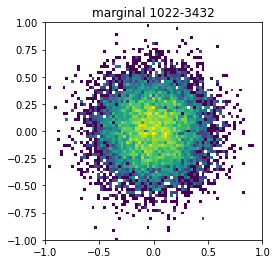

In [309]:
from matplotlib.colors import LogNorm
i = np.random.randint(0, dim)
j = np.random.randint(0, dim)
plt.title(f'marginal {i}-{j}')
# plt.hist2d(target_data[:,i].cpu().numpy(), target_data[:,j].cpu().numpy(), bins=75, norm=LogNorm())
plt.hist2d(mapped_samples[:,i].cpu().numpy(), mapped_samples[:,j].cpu().numpy(), bins=75, norm=LogNorm())
plt.gca().set_box_aspect(1)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

In [310]:
# prior._delegate_sampler.reshuffle_()
# with torch.no_grad():
#     z = prior.sample(n_samples)
#     prior_ene = prior.energy(z).view(-1).cpu().numpy()
#     x, dlogp = flow(z)
#     target_ene = target.energy(x).view(-1).cpu().numpy()
#     dlogp = dlogp.view(-1).cpu().numpy()

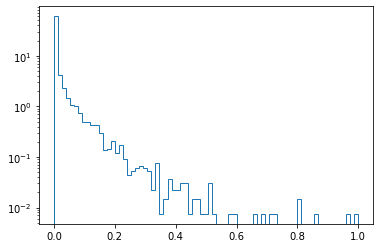

In [311]:
# plt.hist(prior_ene, **hist_opt)
# plt.hist(target_ene, **hist_opt)
# plt.hist(prior_ene-target_ene, **hist_opt)
# plt.hist(prior_ene+dlogp-target_ene, **hist_opt)
plt.hist(logw.exp().view(-1).cpu().numpy(), **hist_opt)
# plt.hist(dlogp, **hist_opt)
plt.yscale('log')
plt.show()

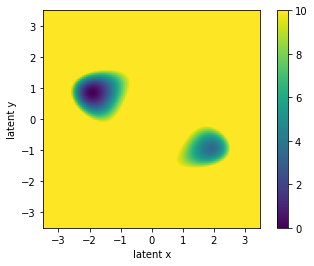

In [312]:
plot_latent(flow, vmax=10)
maskA = np.array([y>x+1.3 for x,y in data[:,0,:2]])
if dim == 2:
    plot_latent(flow, flow(torch.as_tensor(data[maskA,:,:dim], **ctx).view(-1,dim), inverse=True)[0], flow(torch.as_tensor(data[~maskA,:,:dim], **ctx).view(-1,dim), inverse=True)[0])

In [313]:
# for i in range(1,6):
#     mydim = 2**(2*i)
#     potential = bg.ModifiedWolfeQuapp(mydim)
#     print(f'i={i}, dim={mydim}, n~{2**i//2}')
#     logw = potential.energy(prior_data[:,:mydim], temperature=highT*kB) - potential.energy(prior_data[:,:mydim])
#     print(f'Sampling efficiency: {bg.sampling_efficiency(logw).item():e}')
#     print(f'ESS: {bg.effective_sample_size(logw).item():g}')
#     plt.hist(potential.energy(prior_data[:,:mydim]).view(-1).cpu(), **hist_opt, label='prior')
#     plt.hist(potential.energy(target_data[:,:mydim]).view(-1).cpu(), **hist_opt, label='target')
#     plt.legend()
#     plt.show()

In [314]:
# for i in range(1,6):
#     mydim = 2**(2*i)
#     print(f'i={i}, dim={mydim}, n~{2**i//2}')
#     ener = np.load(f'energies-dim{mydim}.npz')
#     logw = torch.as_tensor(np.log(ener['weights']))
#     print(f' Sampling efficiency: {bg.sampling_efficiency(logw).item():.1%}')
#     print(f' ESS: {bg.effective_sample_size(logw).item():g}')
#     plt.hist(ener['target'], **hist_opt, label='target')
#     plt.hist(ener['mapped'], **hist_opt, label='mapped')
#     # plt.hist(ener['prior'], **hist_opt, label='prior')
#     plt.legend()
#     plt.show()

In [315]:
# raise SystemError('Stop')

## LREX

In [316]:
%%time

pace = 100
n_iter = 10_000
mc_stride = 1

n_replicas = 2
temperatures = [temp, highT]
modelMD = WolfeQuappOpenMM(dim)
initial_pos = [modelMD.positions] * n_replicas
integrator = []
simulation = []
for i in range(n_replicas):
    integrator.append(openmm.LangevinMiddleIntegrator(temperatures[i]*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond))
    simulation.append(openmm.app.Simulation(modelMD.topology, modelMD.system, integrator[i]))
    simulation[i].context.setPositions(initial_pos[i])

n_equil = 100
for i in range(n_replicas):
    print('equilibrating...', i, end='\r')
    simulation[i].step(n_equil*pace)

CPU times: user 274 ms, sys: 175 ms, total: 449 ms
Wall time: 473 ms


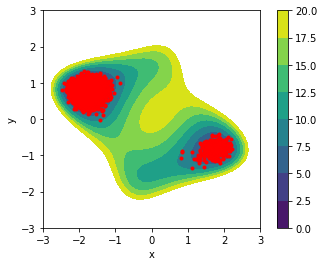

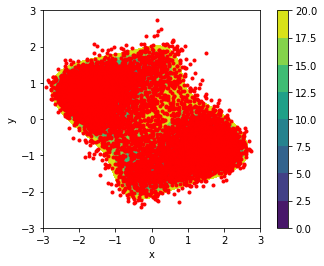

CPU times: user 3min 54s, sys: 9.68 s, total: 4min 4s
Wall time: 3min 51s


In [317]:
%%time

data = np.full((n_replicas, n_iter, *modelMD.positions.shape), np.nan)
is_swapped = np.full(n_iter, False)
for n in range(n_iter):
    for i in range(n_replicas):
        simulation[i].step(pace)
        data[i][n] = simulation[i].context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometer)
    if n % mc_stride == 0:           
        with torch.no_grad():
            z_h = torch.as_tensor(data[1][n], **ctx).view(1, modelMD.base_dim)[:,:dim]
            x_h, dlogp_h = flow(z_h, inverse=False)
            logw_h = prior.energy(z_h) + dlogp_h - target.energy(x_h)

            x_l = torch.as_tensor(data[0][n], **ctx).view(1, modelMD.base_dim)[:,:dim]
            z_l, dlogp_l = flow(x_l, inverse=True)
            logw_l = target.energy(x_l) + dlogp_l - prior.energy(z_l)
        
        delta_energy = -(logw_h + logw_l).item()
        if delta_energy <= 0.0 or np.random.rand() < np.exp(-delta_energy):
            is_swapped[n] = True
            # new_pos = np.resize(assert_numpy(x_h), modelMD.positions.shape)
            simulation[0].context.setPositions(np.resize(assert_numpy(x_h), modelMD.positions.shape))
            simulation[0].context.setVelocitiesToTemperature(temperatures[0])
            # new_pos = np.resize(assert_numpy(z_l), modelMD.positions.shape)
            simulation[1].context.setPositions(np.resize(assert_numpy(z_l), modelMD.positions.shape))
            simulation[1].context.setVelocitiesToTemperature(temperatures[1])
    if (n+1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plot_doublewell(data[0,:n+1,:])
        plot_doublewell(data[1,:n+1,:])
    print(f'sampling...  {(n+1)/n_iter:.1%}, accepted: {mc_stride*is_swapped[:n+1].sum()/(n+1):.2%}', end='\r')

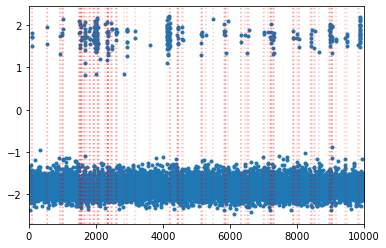

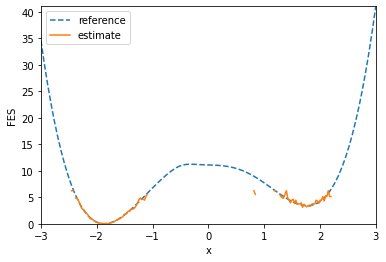

ref DeltaF: 3.31506 [kBT]
    DeltaF: 3.34376 [kBT]


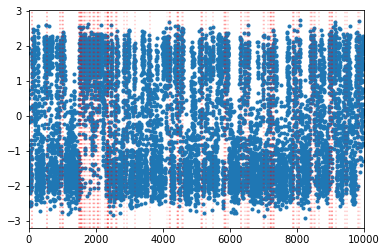

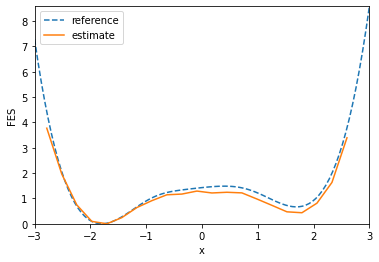

ref DeltaF: 0.52824 [kBT]
    DeltaF: 0.338393 [kBT]


In [318]:
diff = np.array(data[0, :, 0, 0]*data[1, :, 0, 0] < 0)
for i in range(n_replicas):
    plt.plot(data[i, :, 0, 0], ".")
    for sw in np.where(is_swapped)[0]:
        if diff[sw]: #highlight only useful exchanges
            plt.axvline(sw, c='r', ls=':', alpha=.1)
    plt.xlim(0, n_iter)
    plt.show()
    plot_fes(data[i, :, 0, 0], temperatures[i])
    plt.show()

Fraction of accepted exchanges: 14.12%
  of which between different states: 15.30%
Fraction of accepted exchanges between different states: 2.16%


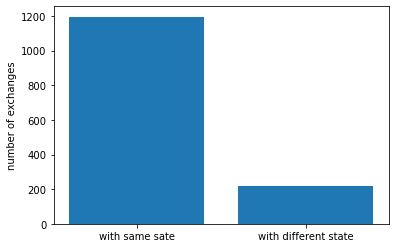

In [320]:
assert mc_stride == 1
diff_sw = diff[is_swapped].sum()
plt.bar(
    ["with same sate", "with different state"], [is_swapped.sum()-diff_sw, diff_sw]
)
plt.ylabel("number of exchanges")

# print('Tot exchanges with lowest prob state:', (state_h == 7).sum())
print(f"Fraction of accepted exchanges: {is_swapped.sum()/len(is_swapped):.2%}")
print(f"  of which between different states: {diff_sw/is_swapped.sum():.2%}")
print(f"Fraction of accepted exchanges between different states: {diff_sw/len(is_swapped):.2%}")

In [321]:
np.save(f'dw-LREX-N{dim}', data[0,:,0, 0])

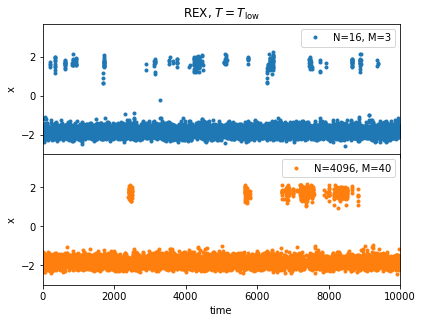

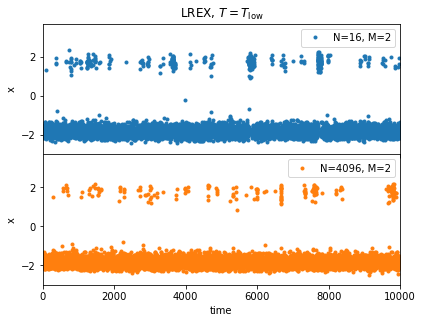

In [218]:
def plot_sup_fig(method):
    fig = plt.figure(figsize=(6.4, 4.8))
    gs = fig.add_gridspec(2, 1, hspace=0)#, hspace=0)
    axs = gs.subplots(sharex=True, sharey=True)
    axs[0].set_title(method+', $T=T_{\mathrm{low}}$')
    axs[0].set_xlim(0, 10_000)
    axs[1].set_xlabel('time')
    axs[0].set_ylim(-3, 3.7)
    axs[0].set_ylabel('x')
    axs[1].set_ylabel('x')
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    M = 2 if method == 'LREX' else 3
    axs[0].plot(np.load(f'dw-{method}-N16.npy'), '.', c=colors[0], label=f'N=16, M={M}')
    M = 2 if method == 'LREX' else 40
    axs[1].plot(np.load(f'dw-{method}-N4096.npy'), '.', c=colors[1], label=f'N=4096, M={M}')
    axs[0].legend()
    axs[1].legend()
    plt.show()

plot_sup_fig('REX')
plot_sup_fig('LREX')